In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import funciones_auxiliares as aux

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (15, 6)

# Feature Engineering

In [2]:
df = pd.read_csv("RegistroTumores_FALP.csv")


In [3]:
# Deja solo el cancer de mama
mama = df.query("CATEGORIA == 'MAMA'")

# Deja solo los registros con estadio
mama_con_estadio = mama[~mama["ESTADIO"].isna()]

# Deja solo los registros sin estadio
mama_sin_estadio = mama[mama["ESTADIO"].isna()]

In [4]:
mama_preproc = aux.preprocesar_dataset_cancer_mama(mama_con_estadio)
mama_sin_estadio_preproc = aux.preprocesar_dataset_cancer_mama(mama_sin_estadio)


In [5]:
mama_preproc

,SEXO,REGION,COMUNA,PREVISION,CONVENIO_ONCOLOGICO,CT,CN,CM,PT,PN,PM,EXTENSION_DIAGNOSTICO,ESTADO_VITAL,TTO_FALP_SUBCATEGORIA,RANGO_ETARIO,STATUS
4865,F,metropolitana,san ramon,BENEFICIARIO,NO,T1,N1,M0,T1,N1,M0,LOCAL,VIVO,QUIMIOTERAPIA,15 a 64 anios,2
4866,F,metropolitana,san ramon,BENEFICIARIO,NO,T1,N1,M0,T1,N1,M0,LOCAL,VIVO,QUIMIOTERAPIA,15 a 64 anios,2
4867,F,metropolitana,santiago,ISAPRE,SI,T2,N0,M0,T2,N0,M0,LOCAL,VIVO,QUIMIOTERAPIA + INMUNOTERAPIA,65 y mas anios,1
4868,F,metropolitana,santiago,ISAPRE,SI,T2,N0,M0,T2,N0,M0,LOCAL,VIVO,CIRUGÍA,65 y mas anios,1
4869,F,metropolitana,santiago,ISAPRE,SI,T2,N0,M0,T2,N0,M0,LOCAL,VIVO,CIRUGÍA,65 y mas anios,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19098,F,metropolitana,lo prado,BENEFICIARIO,NO,T2,N3,M0,SO,SO,SO,REGIONAL,VIVO,HORMONOTERAPIA,65 y mas anios,3
19103,F,metropolitana,maipu,ISAPRE,SO,T3,N2,M0,T0,N0,Mx,REGIONAL,VIVO,INMUNOTERAPIA,15 a 64 anios,3
19104,F,metropolitana,maipu,ISAPRE,SO,T3,N2,M0,T0,N0,Mx,REGIONAL,VIVO,CIRUGÍA,15 a 64 anios,3
19105,F,metropolitana,maipu,ISAPRE,SO,T3,N2,M0,T0,N0,Mx,REGIONAL,VIVO,QUIMIOTERAPIA + INMUNOTERAPIA,15 a 64 anios,3


In [34]:
X = mama_preproc.drop(columns="STATUS")
y = mama_preproc["STATUS"]

In [35]:
encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown="ignore")
encoder.fit(X)

X = encoder.transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=1)


# Modelacion

## Declaracion de modelos y grillas de hiperparametros

In [9]:
modelos = [
    {
        "nombre": "Naive Bayes",
        "modelo": MultinomialNB(),
        "param_grid": {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            "fit_prior": [True, False],
        },
    },
    {
        "nombre": "Arbol Clasificacion",
        "modelo": DecisionTreeClassifier(),
        "param_grid": {
            "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
            "max_leaf_nodes": [10, 50, 100],
            "criterion": ["gini", "entropy"],
            "min_samples_split": [0.05, 2],
        },
    },
    {
        "nombre": "Random Forest",
        "modelo": RandomForestClassifier(min_samples_split=2),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "n_estimators": [500, 600, 700, 800, 900, 1000],
            "max_leaf_nodes": [10, 50, 100],
        },
    },
    {
        "nombre": "Gradient Bossting",
        "modelo": GradientBoostingClassifier(min_samples_split=2),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "learning_rate": [0.001, 0.01, 0.1, 1],
            "max_leaf_nodes": [10, 50, 100],
        },
    },
    {
        "nombre": "SVM",
        "modelo": SVC(),
        "param_grid": {"C": [0.1, 1, 10, 100], "kernel": ["linear", "poly"], "degree": [2, 3, 4]},
    },
]

## Entrenamiento de Modelos

Training Naive Bayes ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


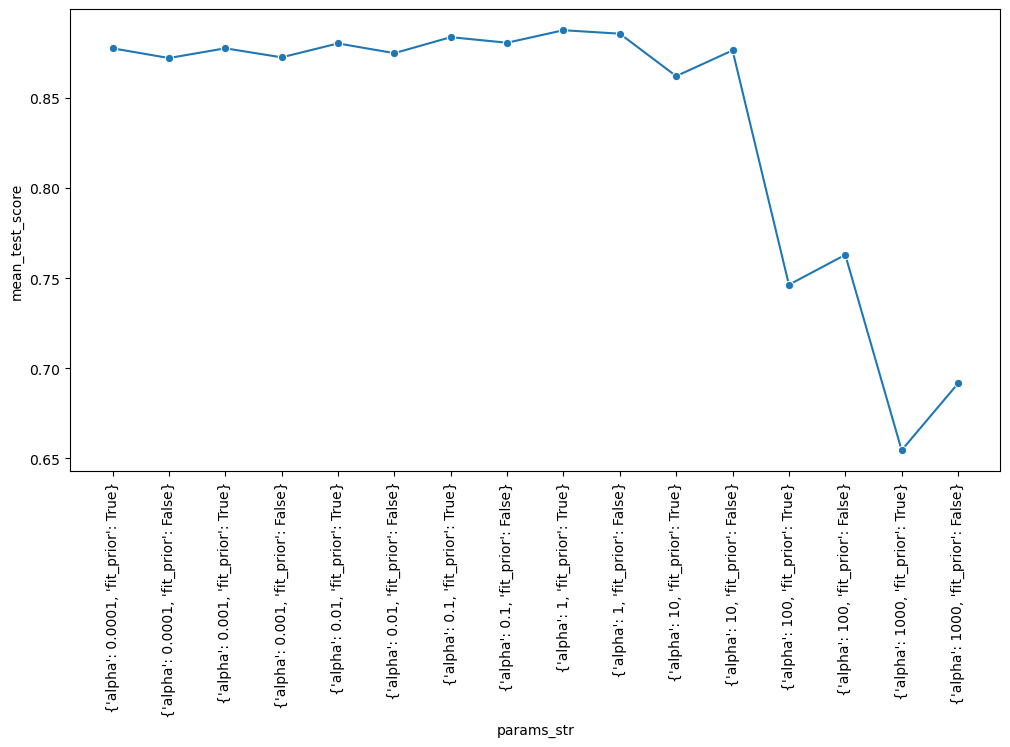

Los mejores parametros fueron: {'alpha': 1, 'fit_prior': True}
El mejor desempeno fue: 0.8876834720765358


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.94      0.93      0.93       446
           2       0.83      0.86      0.84       488
           3       0.88      0.84      0.86       361

    accuracy                           0.88      1295
   macro avg       0.88      0.88      0.88      1295
weighted avg       0.88      0.88      0.88      1295

---------------------------------------------------------------------
Training Arbol Clasificacion ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


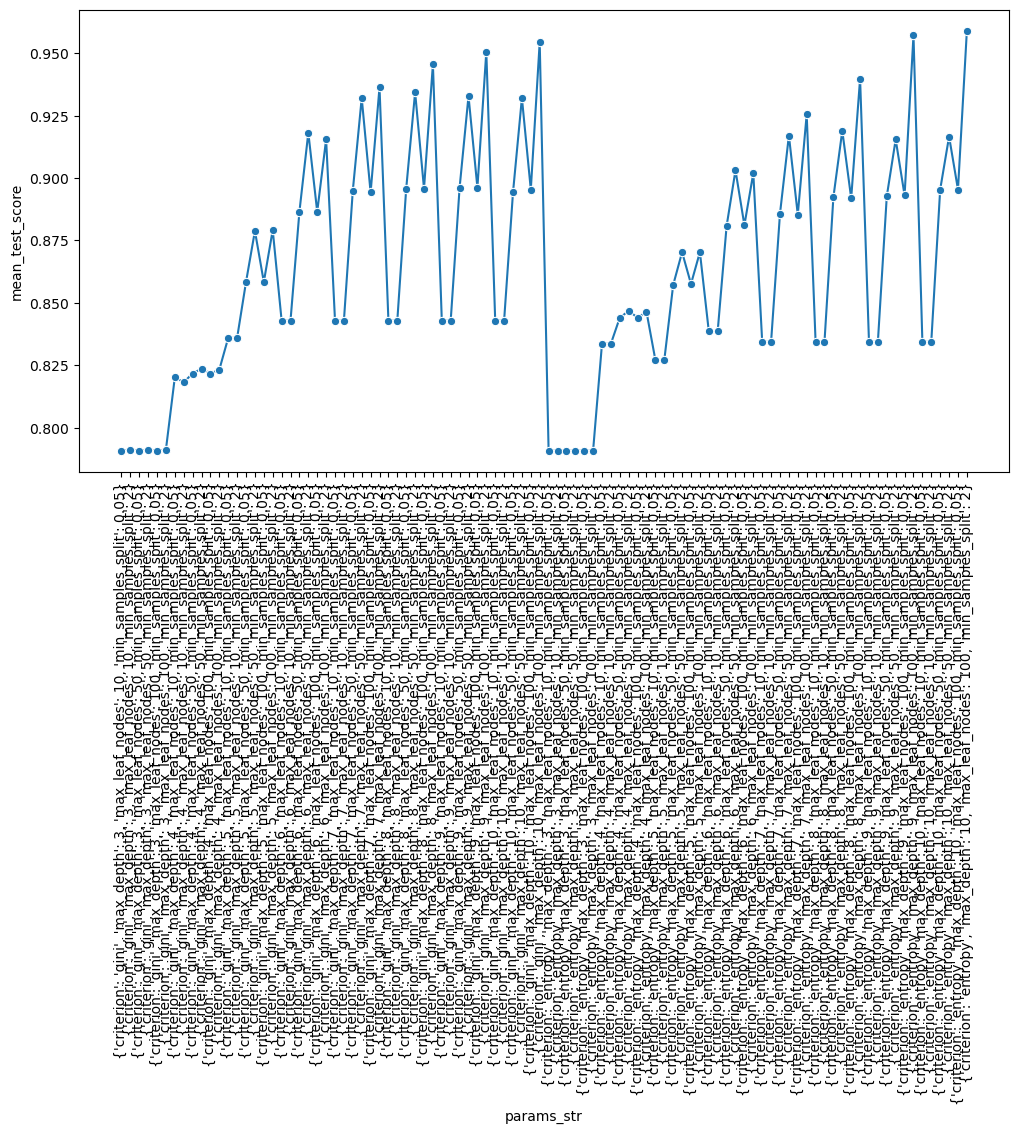

Los mejores parametros fueron: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_split': 2}
El mejor desempeno fue: 0.9590919573578531


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.99      0.95      0.97       446
           2       0.93      1.00      0.96       488
           3       1.00      0.97      0.98       361

    accuracy                           0.97      1295
   macro avg       0.97      0.97      0.97      1295
weighted avg       0.97      0.97      0.97      1295

---------------------------------------------------------------------
Training Random Forest ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


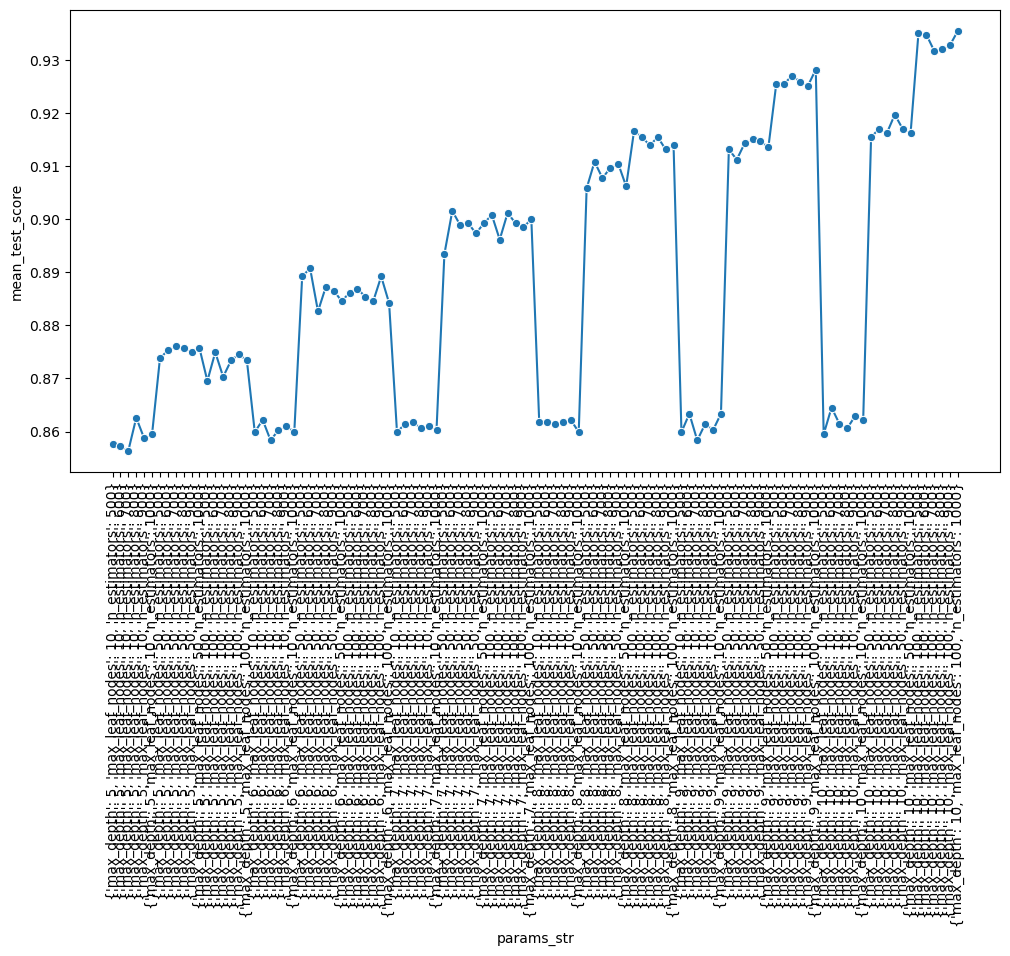

Los mejores parametros fueron: {'max_depth': 10, 'max_leaf_nodes': 100, 'n_estimators': 1000}
El mejor desempeno fue: 0.9355405777371096


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.97      0.93      0.95       446
           2       0.89      0.97      0.93       488
           3       0.99      0.92      0.95       361

    accuracy                           0.94      1295
   macro avg       0.95      0.94      0.94      1295
weighted avg       0.94      0.94      0.94      1295

---------------------------------------------------------------------
Training Gradient Bossting ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


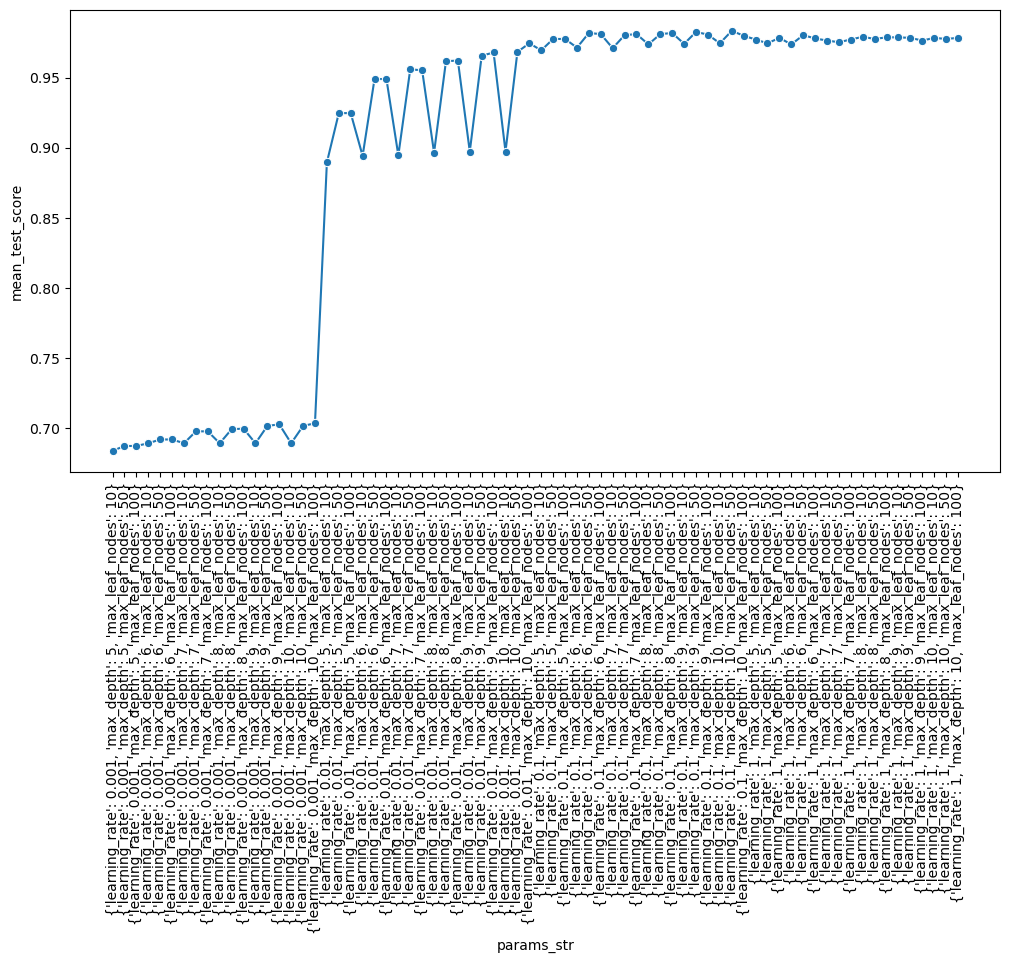

Los mejores parametros fueron: {'learning_rate': 0.1, 'max_depth': 10, 'max_leaf_nodes': 50}
El mejor desempeno fue: 0.9834058666428609


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       446
           2       0.98      1.00      0.99       488
           3       1.00      0.99      1.00       361

    accuracy                           0.99      1295
   macro avg       0.99      0.99      0.99      1295
weighted avg       0.99      0.99      0.99      1295

---------------------------------------------------------------------
Training SVM ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


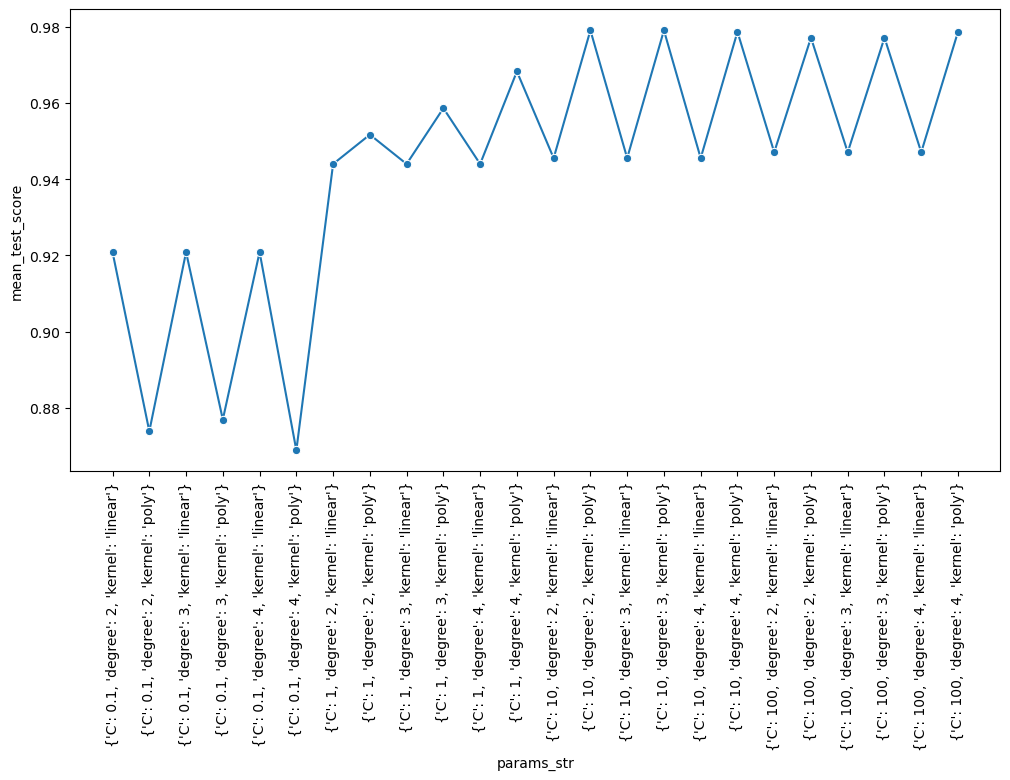

Los mejores parametros fueron: {'C': 10, 'degree': 2, 'kernel': 'poly'}
El mejor desempeno fue: 0.979160994189896


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       446
           2       0.97      0.99      0.98       488
           3       0.99      0.99      0.99       361

    accuracy                           0.98      1295
   macro avg       0.98      0.98      0.98      1295
weighted avg       0.98      0.98      0.98      1295

---------------------------------------------------------------------


In [10]:
aux.entrenar_ensamble_de_modelos_gridcv(modelos, X_train, X_test, y_train, y_test)


## Resumen resultados

- Los resultados de todos los modelos entrenados fueron los siguientes:

|Modelo|Accuracy en Grid Search|Validacion - Recall 1|Validacion - Recall 2|Validacion - Recall 3|Validacion - Accuracy|
|------|-----------------------|---------------------|---------------------|---------------------|---------------------|
Naive Bayes|0.88|0.93|0.86|0.83|0.88|
Arbol de Clasificacion|0.96|0.95|0.99|0.97|0.97|
Random Forest|0.93|0.93|0.97|0.92|0.94|
Gradient Boosting|0.98|0.98|1.00|0.99|0.99|
SVM|0.98|0.97|0.99|0.99|0.98|

- Se puede observar que la mayoria de los modelos (exceptuando Naive Bayes, presentan desempenos
sobre 0.9)

- Al centrarse en las metricas de recall (1, 2, y 3) se observa que el modelo de Gradient Boosting
es el mejor de todos. Esto, ya que presenta el mayor recall en las clases 1 y 2. Por otro lado,
presenta el mismo desempeno de recall 3 que el modelo SVM. 

- Al centrarse en la metrica de accuracy de validacion, se observa que el modelo de Gradient Boosting
presenta el valor mas alto (0.99).

- Por lo tanto, el mejor modelo entrenado es el de Gradient Boosting

## Exportacion de Modelos Entrenados

In [11]:
with open("modelos_serializados_cancer_mama.pickle", "wb") as file:
    pickle.dump(modelos, file)


In [12]:
with open("modelos_serializados_cancer_mama.pickle", "rb") as file:
    modelos_importados = pickle.load(file)

## Prediccion con datos que carecen de estadio

In [13]:
X_val = encoder.transform(mama_sin_estadio_preproc.drop(columns="STATUS"))
yhat = modelos[3]["modelo"].predict(X_val)

In [14]:
mama_sin_estadio_preproc["STATUS_pred"] = yhat

In [15]:
display(mama_sin_estadio_preproc)

,SEXO,REGION,COMUNA,PREVISION,CONVENIO_ONCOLOGICO,CT,CN,CM,PT,PN,PM,EXTENSION_DIAGNOSTICO,ESTADO_VITAL,TTO_FALP_SUBCATEGORIA,RANGO_ETARIO,STATUS,STATUS_pred
5813,F,valparaiso,vina del mar,ISAPRE,SI,T0,N0,M0,Tis,N0,M0,LOCAL,VIVO,RADIOTERAPIA,Adultez,SO,1
5814,F,valparaiso,vina del mar,ISAPRE,SI,T0,N0,M0,Tis,N0,M0,LOCAL,VIVO,CIRUGÍA,Adultez,SO,1
5815,F,valparaiso,vina del mar,ISAPRE,SI,T0,N0,M0,Tis,N0,M0,LOCAL,VIVO,HORMONOTERAPIA,Adultez,SO,1
5911,F,magallanes y antartica chilena,punta arenas,BENEFICIARIO,NO,Tis,N0,M0,Tis,N0,M0,LOCAL,VIVO,CIRUGÍA,Adultez,SO,1
5912,F,magallanes y antartica chilena,punta arenas,BENEFICIARIO,NO,Tis,N0,M0,Tis,N0,M0,LOCAL,VIVO,CIRUGÍA,Adultez,SO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18021,F,metropolitana,las condes,FONASA,NO,T2,N0,M0,SO,SO,SO,LOCAL,VIVO,RADIOTERAPIA,Adultez,SO,2
18022,F,metropolitana,las condes,FONASA,NO,T2,N0,M0,SO,SO,SO,LOCAL,VIVO,QUIMIOTERAPIA,Adultez,SO,2
18023,F,metropolitana,las condes,FONASA,NO,T2,N0,M0,SO,SO,SO,LOCAL,VIVO,QUIMIOTERAPIA,Adultez,SO,2
18024,F,metropolitana,las condes,FONASA,NO,T2,N0,M0,SO,SO,SO,LOCAL,VIVO,QUIMIOTERAPIA + INMUNOTERAPIA,Adultez,SO,2


- Por lo tanto, se observa que es posible asignar un estadio a 269 pacientes que carecen de uno.

In [16]:
mama_sin_estadio_preproc.query("STATUS_pred == 3")

,SEXO,REGION,COMUNA,PREVISION,CONVENIO_ONCOLOGICO,CT,CN,CM,PT,PN,PM,EXTENSION_DIAGNOSTICO,ESTADO_VITAL,TTO_FALP_SUBCATEGORIA,RANGO_ETARIO,STATUS,STATUS_pred
6805,F,libertador gral. b. o'higgins,peumo,BENEFICIARIO,NO,T4,Nx,SO,SO,SO,SO,SO,VIVO,SO,Vejez,SO,3
7948,F,metropolitana,providencia,PARTICULAR,NO,SO,SO,SO,T2,N2,M0,REGIONAL,VIVO,CIRUGÍA,Adultez,SO,3
11438,F,metropolitana,las condes,BENEFICIARIO,SI,SO,SO,M0,SO,SO,SO,REGIONAL,VIVO,CIRUGÍA,Vejez,SO,3
11439,F,metropolitana,las condes,BENEFICIARIO,SI,SO,SO,M0,SO,SO,SO,REGIONAL,VIVO,HORMONOTERAPIA,Vejez,SO,3
11440,F,metropolitana,las condes,BENEFICIARIO,SI,SO,SO,M0,SO,SO,SO,REGIONAL,VIVO,CIRUGÍA,Vejez,SO,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17606,F,metropolitana,las condes,ISAPRE,SI,SO,SO,SO,T1,N0,SO,SO,VIVO,HORMONOTERAPIA,Vejez,SO,3
17687,F,metropolitana,melipilla,FONASA,NO,T1,N1,M0,T0,N2,Mx,REGIONAL,VIVO,RADIOTERAPIA,Vejez,SO,3
17961,F,coquimbo,ovalle,FONASA,SI,SO,SO,SO,T1,N0,SO,SO,VIVO,HORMONOTERAPIA,Adultez,SO,3
17962,F,coquimbo,ovalle,FONASA,SI,SO,SO,SO,T1,N0,SO,SO,VIVO,CIRUGÍA,Adultez,SO,3


- Ademas, se predijo que 72 pacientes presentan un estadio nivel 3. Esto podria permitir la atencion
urgente de tales pacientes.

## Control de calidad

In [17]:
prediccion = modelos[3]["modelo"].predict(X_test)

In [18]:
concatenacion = pd.DataFrame({"test": y_test, "yhat": prediccion})